In [2]:
import numpy as np
import json
import warnings
import operator

import h5py
from keras.models import model_from_json
from keras import backend as K

from matplotlib import pyplot as plt

warnings.filterwarnings("ignore")

size_title = 18
size_label = 14
n_pred = 2 

base_path = "data/evaluate_bayesian_opt/" # cluster path: bayesian_opt/similar_galaxy_workflow

path_data_dict = base_path + "data_dict.txt"
path_usage_wt = base_path + "usage_prediction.txt"
path_class_wt = base_path + "class_weights.txt"
path_test_data = base_path + "test_paths_dict.txt"
model_path = base_path + "trained_model.hdf5"

def read_file(file_path):
    with open(file_path, 'r') as data_file:
        data = json.loads(data_file.read())
    return data

class_weights = read_file(path_class_wt)
usage_weights = read_file(path_usage_wt)
data_dict = read_file(path_data_dict)

def create_model(model_path):
    trained_model = h5py.File(model_path, 'r')
    model_config = json.loads(trained_model.get('model_config').value)
    loaded_model = model_from_json(model_config)
    dictionary = json.loads(trained_model.get('data_dictionary').value)
    compatibile_tools = json.loads(trained_model.get('compatible_tools').value)
    best_params = json.loads(trained_model.get('best_parameters').value)
    print(best_params)
    reverse_dictionary = dict((str(v), k) for k, v in dictionary.items())
    model_weights = list()
    weight_ctr = 0
    while True:
        try:
            d_key = "weight_" + str(weight_ctr)
            weights = trained_model.get(d_key).value
            model_weights.append(weights)
            weight_ctr += 1
        except Exception as exception:
            break
    # set the model weights
    loaded_model.set_weights(model_weights)
    return loaded_model, dictionary, reverse_dictionary, compatibile_tools

model, dictionary, reverse_dictionary, compatibile_tools = create_model(model_path)

{'activation_output': 'sigmoid', 'activation_recurrent': 'elu', 'batch_size': 494.0, 'dropout': 0.18513050375862405, 'embedding_size': 471.0, 'learning_rate': 0.0030965078342944114, 'recurrent_dropout': 0.23176041572885914, 'spatial_dropout': 0.0030467677786883696, 'units': 373.0}


In [4]:
reverse_dictionary

{'1': 'minfi_methcpg',
 '2': 'genbank_to_gff',
 '3': 'sklearn_numeric_clustering',
 '4': 'edger',
 '5': 'heatmapper_deepTools',
 '6': 'FidoAdapter',
 '7': 'samtools_filter',
 '8': 'deeptools_compute_gc_bias',
 '9': 'idpquery',
 '10': 'deeptools_plot_correlation',
 '11': 'cshl_fastx_artifacts_filter',
 '12': 'mass_spectrometry_imaging_ion_images',
 '13': 'get_sequences',
 '14': 'FeatureLinkerUnlabeled',
 '15': 'silac_analyzer',
 '16': 'dbbuilder',
 '17': 'sailfish',
 '18': 'FROGS_clustering',
 '19': 'gops_subtract_1',
 '20': 'gops_basecoverage_1',
 '21': 'histogram_rpy',
 '22': 'sequence_content_trimmer',
 '23': 'cardinal_quality_report',
 '24': 'cuffdiff',
 '25': 'wig_to_bigWig',
 '26': 'EMBOSS: getorf42',
 '27': 'cardinal_mz_images',
 '28': 'samtools_split',
 '29': 'HighResPrecursorMassCorrector',
 '30': 'proteomics_moff',
 '31': 'bedtools_mergebed',
 '32': 'minfi_getM',
 '33': 'rgPicardMarkDups',
 '34': 'ggplot2_point',
 '35': 'minfi_getbeta',
 '36': 'rnafold',
 '37': 'mimodd_varrepo

In [13]:
def verify_model(model, tool_sequence, labels, dictionary, reverse_dictionary, compatible_tools, topk=20, max_seq_len=25):
    tl_seq = tool_sequence.split(",")
    last_tool_name = reverse_dictionary[str(tl_seq[-1])]
    last_compatible_tools = compatible_tools[last_tool_name]
    sample = np.zeros(max_seq_len)
    for idx, tool_id in enumerate(tl_seq):
        sample[idx] = int(tool_id)
    sample_reshaped = np.reshape(sample, (1, max_seq_len))

    tool_sequence_names = [reverse_dictionary[str(tool_pos)] for tool_pos in tool_sequence.split(",")]
    print("Tool seq: %s" % ",".join(tool_sequence_names))

    # predict next tools for a test path
    prediction = model.predict(sample_reshaped, verbose=0)
    prediction = np.reshape(prediction, (prediction.shape[1],))
    prediction_pos = np.argsort(prediction, axis=-1)

    # get topk prediction
    topk_prediction_pos = prediction_pos[-topk:]
    topk_prediction_val = [np.round(prediction[pos] * 100, 2) for pos in topk_prediction_pos]

    # read tool names using reverse dictionary
    pred_tool_ids = [reverse_dictionary[str(tool_pos)] for tool_pos in topk_prediction_pos]
    actual_next_tool_ids = list(set(pred_tool_ids).intersection(set(last_compatible_tools.split(","))))      

    print()
    pred_tool_ids_sorted = dict()
    for (tool_pos, tool_pred_val) in zip(topk_prediction_pos, topk_prediction_val):
        tool_name = reverse_dictionary[str(tool_pos)]
        if tool_name in actual_next_tool_ids:
            pred_tool_ids_sorted[tool_name] = tool_pred_val
    pred_tool_ids_sorted = dict(sorted(pred_tool_ids_sorted.items(), key=lambda kv: kv[1], reverse=True))
    
    cls_wt = dict()
    usg_wt = dict()
    inv_wt = dict()
    ids_tools = dict()
    keys = list(pred_tool_ids_sorted.keys())
    for k in keys:
        try:
            cls_wt[k] = np.round(class_weights[str(data_dict[k])], 2)
            usg_wt[k] = np.round(usage_weights[k], 2)
            inv_wt[k] = np.round(inverted_weights[str(data_dict[k])], 2)
        except:
            continue
    print("Predicted tools: \n")
    print(pred_tool_ids_sorted)
    print()
    print("Class weights: \n")
    cls_wt = dict(sorted(cls_wt.items(), key=lambda kv: kv[1], reverse=True))
    print(cls_wt)
    print()
    print("Usage weights: \n")
    usg_wt = dict(sorted(usg_wt.items(), key=lambda kv: kv[1], reverse=True))
    print(usg_wt)
    print()
    total_usage_wt = np.mean(list(usg_wt.values()))
    print("Mean usage wt: %0.4f" % (total_usage_wt))
    print()
    print("Inverted weights: \n")
    inv_wt = dict(sorted(inv_wt.items(), key=lambda kv: kv[1], reverse=True))
    print(inv_wt)
    for key in pred_tool_ids_sorted:
        ids_tools[key] = dictionary[key]
    print()
    print("Tool ids")
    print(ids_tools)
    print("======================================")
    return cls_wt, usg_wt, inv_wt, pred_tool_ids_sorted

topk = 20
tool_seq = "949,266,781"
class_wt, usage_wt, inverse_wt, pred_tools = verify_model(model, tool_seq, "", dictionary, reverse_dictionary, compatibile_tools, topk)

Tool seq: trimmomatic,rna_star,featurecounts

Predicted tools: 

{'deseq2': 87.84, 'multiqc': 46.43, 'Filter1': 30.07, 'collection_column_join': 18.18, 'sort1': 15.38, 'tp_sort_header_tool': 3.96, 'Add_a_column1': 2.39, 'Cut1': 0.96, 'tp_easyjoin_tool': 0.64}

Class weights: 

{'Cut1': 1425.46, 'Filter1': 1021.1, 'tp_easyjoin_tool': 525.68, 'deseq2': 489.0, 'tp_sort_header_tool': 471.9, 'multiqc': 434.46, 'sort1': 68.5, 'collection_column_join': 14.1, 'Add_a_column1': 1.0}

Usage weights: 

{'Cut1': 1425.46, 'Filter1': 1021.1, 'tp_easyjoin_tool': 525.68, 'deseq2': 489.0, 'tp_sort_header_tool': 471.9, 'multiqc': 434.46, 'sort1': 68.5, 'collection_column_join': 14.1, 'Add_a_column1': 1.0}

Mean usage wt: 494.5778

Inverted weights: 

{}

Tool ids
{'deseq2': 666, 'multiqc': 589, 'Filter1': 780, 'collection_column_join': 111, 'sort1': 812, 'tp_sort_header_tool': 157, 'Add_a_column1': 774, 'Cut1': 470, 'tp_easyjoin_tool': 723}


"plt.figure(figsize = (8, 6))\nsns.kdeplot(batch_size_uni, color = 'red', linewidth = 2, shade = True);\nplt.title('Batch Size Distribution Uniform', size = 18); \nplt.xlabel('Batch Size', size = 16); plt.ylabel('Density', size = 16);"

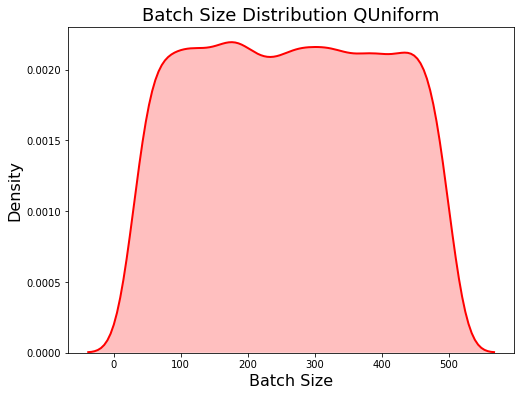

In [17]:
from hyperopt import hp
from hyperopt.pyll.stochastic import sample

import matplotlib.pyplot as plt
import seaborn as sns

# Create the learning rate
#learning_rate = {'learning_rate': hp.uniform('learning_rate', 0.005, 0.2)}
batch_size = {'batch_size': hp.uniform('batch_size', 30, 500)}
#batch_size_uni = {'batch_size': hp.uniform('batch_size', 32, 512, 1)}

#learning_rate = {'learning_rate': hp.loguniform('learning_rate', np.log(1e-4), np.log(1e-2))}

learning_rate_dist = list()
batch_size_dist = list()
batch_size_uni = list()
for _ in range(10000):
    #learning_rate_dist.append(sample(learning_rate)['learning_rate'])
    batch_size_dist.append(sample(batch_size)['batch_size'])
    #batch_size_uni.append(sample(batch_size)['batch_size'])

#plt.figure(figsize = (8, 6))
#sns.kdeplot(learning_rate_dist, color = 'red', linewidth = 2, shade = True);
#plt.title('Learning Rate Distribution', size = 18); 
#plt.xlabel('Learning Rate', size = 16); plt.ylabel('Density', size = 16);

plt.figure(figsize = (8, 6))
sns.kdeplot(batch_size_dist, color = 'red', linewidth = 2, shade = True);
plt.title('Batch Size Distribution QUniform', size = 18); 
plt.xlabel('Batch Size', size = 16); plt.ylabel('Density', size = 16);

'''plt.figure(figsize = (8, 6))
sns.kdeplot(batch_size_uni, color = 'red', linewidth = 2, shade = True);
plt.title('Batch Size Distribution Uniform', size = 18); 
plt.xlabel('Batch Size', size = 16); plt.ylabel('Density', size = 16);'''